In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import numpy as np
sess = tf.Session()

D:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('lowbwt.txt', 'r') as file:
    birth_data = [[float(data) for data in line.strip('\n').split()] for line in file.readlines()]

In [3]:
birth_header = ["ID", "LBW", "AGE", "LWT", "RACE", "SMOKE", "PTL", "HYPER", "URIRR", "PVFT", "BWT"]
cols_of_interest = ['AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HYPER', 'URIRR', 'PVFT']
x_vals = np.array([[x[i] for i, val in enumerate(birth_header) if val in cols_of_interest] for x in birth_data])
y_vals = np.array([y[10] for y in birth_data])

In [4]:
seed = 3
tf.set_random_seed(seed)
np.random.seed(seed)
batch_size = 64

In [5]:
train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
print(type(train_indices[0]))

<class 'numpy.int32'>


In [6]:
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

In [7]:
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m - col_min) / (col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [8]:
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape=shape, stddev=st_dev))
    return weight

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return bias

In [9]:
x_data = tf.placeholder(shape=[None, 8], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [10]:
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return tf.nn.relu(layer)

In [11]:
weight1 = init_weight([8, 25], 10.0)
biases1 = init_bias([25], 10.0)
layer1 = fully_connected(x_data, weight1, biases1)
weight2 = init_weight([25, 10], 10.0)
biases2 = init_bias([10], 10.0)
layer2 = fully_connected(layer1, weight2, biases2)
weight3 = init_weight([10, 3], 10.0)
biases3 = init_bias([3], 10.0)
layer3 = fully_connected(layer2, weight3, biases3)
weight4 = init_weight([3, 1], 10.0)
biases4 = init_bias([1], 10.0)
layer4 = tf.add(tf.matmul(layer3, weight4), biases4)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
loss = tf.reduce_mean(tf.abs(tf.subtract(y_target, layer4)))
my_opt = tf.train.AdamOptimizer(0.05)
train_step = my_opt.minimize(loss)
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
train_loss_vec = []
test_loss_vec = []
y_vals_train = np.transpose([y_vals_train])
y_vals_test = np.transpose([y_vals_test])
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size, replace=False)
    rand_x = x_vals_train[rand_index]
    rand_y = y_vals_train[rand_index]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_train_loss = sess.run(loss, feed_dict={x_data: x_vals_train, y_target: y_vals_train})
    temp_test_loss = sess.run(loss, feed_dict={x_data: x_vals_test, y_target: y_vals_test})
    train_loss_vec.append(temp_train_loss)
    test_loss_vec.append(temp_test_loss)
    if (i + 1) % 50 == 0:
        print("Step {} #  train_loss: {}".format((i + 1), temp_train_loss))

Step 50 #  train_loss: 1704.045166015625
Step 100 #  train_loss: 1002.7144165039062
Step 150 #  train_loss: 811.1849365234375
Step 200 #  train_loss: 747.984619140625
Step 250 #  train_loss: 710.2342529296875
Step 300 #  train_loss: 652.0809936523438
Step 350 #  train_loss: 617.91357421875
Step 400 #  train_loss: 594.2630615234375
Step 450 #  train_loss: 568.7427978515625
Step 500 #  train_loss: 555.388671875


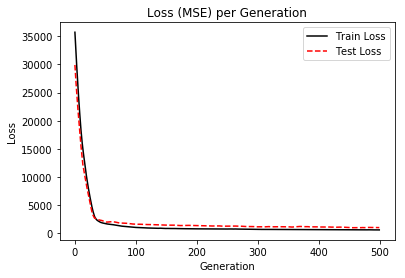

In [15]:
plt.plot(train_loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss_vec, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [16]:
train_pre = sess.run(layer4, feed_dict={x_data: x_vals_train})
train_pre = np.array([1 if y < 2500 else 0 for y in train_pre])
train_target = np.array([1 if y < 2500 else 0 for y in y_vals_train])
train_result = (np.equal(train_pre, train_target)).astype(np.int32)
train_acc = np.sum(train_result) / len(train_result) * 100
test_pre = sess.run(layer4, feed_dict={x_data: x_vals_test})
test_pre = np.array([1 if y < 2500 else 0 for y in test_pre])
test_target = np.array([1 if y < 2500 else 0 for y in y_vals_test])
test_result = (np.equal(test_pre, test_target)).astype(np.int32)
test_acc = np.sum(test_result) / len(test_result) * 100
print("Train accuracy is {}".format(train_acc))
print("Test accuracy is {}".format(test_acc))

Train accuracy is 74.17218543046357
Test accuracy is 60.526315789473685
